In [ ]:
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Assignment 3

This assignment will briefly cover two major types of deep learning models:
discriminative and generative. You will first implement a simple convolutional
neural network (CNN) to classify handwritten digit images from the MNIST
dataset. Then, you will implement a varitional autoencoder (VAE) to generate
images of handwritten digits that mimic the ones in MNIST.

**Models need to be implemented in PyTorch**. If you are new to PyTorch, the
[official tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html)
is a great place to get started.

You need a CUDA-compatible GPU to train the models. If your own computer is
not equipped with one, you can finish this assignment using Google Colab.

## 1. Image Classification with CNN

### 1a. Load and Visualize Data (5 points)

Let's first load the MNIST dataset with the help of TorchVision.

In [ ]:
transform = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(
    root='data', train=True, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.55MB/s]


In the following cell, pick 10 samples from the dataset, and visualize the
images and the corresponding labels using Matplotlib.

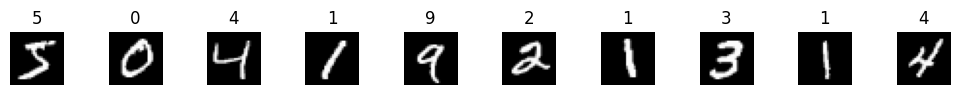

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    image, label = dataset[i]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(str(label))
    axes[i].axis('off')
plt.tight_layout()
plt.show()

We now split the original training set into a training set and a validation set.
The model will be trained on the training set, and the validation set will be
used to tune any hyperparameters.

In [ ]:
# Split the original training set into a training set and a validation set.
generator = torch.Generator().manual_seed(1231)
num_train_samples = int(0.8 * len(dataset))
num_val_samples = len(dataset) - num_train_samples
train_dataset, val_dataset = torch.utils.data.random_split(dataset,
    [num_train_samples, num_val_samples], generator=generator)

device = torch.device('cuda')
# Feel free to change these parameters.
train_kwargs = {
    'batch_size': 64,
    'shuffle': True,
    'num_workers': 1,
    'pin_memory': True,
}
test_kwargs = {
    'batch_size': 64,
    'shuffle': False,
    'num_workers': 1,
    'pin_memory': True,
}

# Create data loaders.
train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, **test_kwargs)

### 1b. Implement CNN (20 points)

In the following cell, implement a neural network that can classify MNIST images
into 10 classes corresponding to digits 0-9. The network should satifies the
following requirements:
- It must contain convolutional layers.
- It takes single-channel images of size 28 x 28 as input, and outputs
  a 10-dimensional score vector for each sample in the batch.
- The output scores should be unnormalized logits (i.e., not the output of a
  softmax layer).

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(
        self,
        x: torch.Tensor,
    ) -> torch.Tensor:
        x = F.relu(self.conv1(x))      # -> (16, 26, 26)
        x = self.pool(x)               # -> (16, 13, 13)
        x = F.relu(self.conv2(x))      # -> (32, 11, 11)
        x = self.pool(x)               # -> (32, 5, 5)
        x = x.view(x.size(0), -1)      # flatten -> (batch_size, 800)
        x = F.relu(self.fc1(x))        # -> (batch_size, 128)
        x = self.fc2(x)

        return x


### 1c. Train the Model (20 points)

Complete the training loop in the following cell and train your model.

Notice the model outputs unnormalized logits, so be sure to choose the
approapriate loss function (`criterion` in the code). You are allowed to use
existing loss functions provided by PyTorch (either the Module version in
`torch.nn` or the function version in `torch.nn.functional`).

You are encouraged to experiment with different optimizers and hyperparameters,
and use any optimizer of your choice in your submission.

In [ ]:
def train(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epoch: int,
    log_interval: int,
) -> None:
    model.train()
    for batch_idx, (data, target) in enumerate(data_loader, start=1):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Epoch {:>2d} [{:>6,}/{:>6,}] loss={:.3f}".format(
                epoch,
                batch_idx * len(data),
                len(data_loader.dataset),
                loss.item(),
            ))


def test(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device,
) -> None:
    model.eval()
    num_correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            num_correct += (pred == target).sum().item()

    print("Test accuracy: {:>6,}/{:>6,} ({:.2f}%)".format(
        num_correct,
        len(data_loader.dataset),
        100. * num_correct / len(data_loader.dataset),
    ))

# TODO
num_epochs = 10
learning_rate = 0.001
# Other hyperparameters:

cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs+1):
    train(cnn, train_loader, criterion, optimizer, device, epoch, log_interval=150)
    test(cnn, val_loader, device)

torch.save(cnn.state_dict(), 'mnist_cnn.pth')

Epoch  1 [ 9,600/48,000] loss=0.302
Epoch  1 [19,200/48,000] loss=0.247
Epoch  1 [28,800/48,000] loss=0.031
Epoch  1 [38,400/48,000] loss=0.151
Epoch  1 [48,000/48,000] loss=0.090
Test accuracy: 11,684/12,000 (97.37%)
Epoch  2 [ 9,600/48,000] loss=0.069
Epoch  2 [19,200/48,000] loss=0.020
Epoch  2 [28,800/48,000] loss=0.013
Epoch  2 [38,400/48,000] loss=0.050
Epoch  2 [48,000/48,000] loss=0.125
Test accuracy: 11,723/12,000 (97.69%)
Epoch  3 [ 9,600/48,000] loss=0.076
Epoch  3 [19,200/48,000] loss=0.007
Epoch  3 [28,800/48,000] loss=0.011
Epoch  3 [38,400/48,000] loss=0.005
Epoch  3 [48,000/48,000] loss=0.002
Test accuracy: 11,819/12,000 (98.49%)
Epoch  4 [ 9,600/48,000] loss=0.107
Epoch  4 [19,200/48,000] loss=0.140
Epoch  4 [28,800/48,000] loss=0.003
Epoch  4 [38,400/48,000] loss=0.052
Epoch  4 [48,000/48,000] loss=0.008
Test accuracy: 11,827/12,000 (98.56%)
Epoch  5 [ 9,600/48,000] loss=0.161
Epoch  5 [19,200/48,000] loss=0.027
Epoch  5 [28,800/48,000] loss=0.021
Epoch  5 [38,400/48,

### 1d. Evaluate the Model on the Test Set (5 points)

In the following cell, load the test split of the MNIST dataset and evaluate
your trained model on it. Report the accuracy of your model.

The test set is supposed to be held out until you have finished model training.
If you have hyperparameters to tune, please do so on the validation set instead
of the test set.

To receive full credit, your model should achieve an accuracy of at least 97.00%
on the test set.

In [ ]:
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test(cnn, test_loader, device)

Test accuracy:  9,915/10,000 (99.15%)


## 2. Image Generation with VAE

In this part, you will implement a variational autoencoder (VAE) that can
generate images of handwriten digits as if they were drawn from the actual MNIST
dataset.

### 2a. Evaluation Metric: Inception Score (5 points)

Before building the model, we first introduce how the generated samples will be
quantitatively evaluated. Specifically, we use the *Inception Score* introduced
in [[link](https://arxiv.org/abs/1606.03498)]. The name comes from applying an
Inception network (pretrained on ImageNet) on generated images, and making use
of statistics of the predicted class probabilities. In this assignment, you're
not going to actually use the Inception network. Instead, you will use the CNN
model you implemented in Q1 as the scoring model.

The idea behind the Inception Score is simple. Ideally, we want the generated
samples to be (1) realistic and (2) diverse. For one specific generated image to
be realistic (i.e., actually look like a handwritten digit), the CNN model
should predict a high score for one and only one of the 10 classes. For the set
of generated images to be diverse, the probabilities should spread out across
the 10 classes when averaged over all generated images. Quantitatively, these
translate to (1) the probability distribution for each sample having low
entropy, and (2) the average probability distribution over all samples having
high entropy.

To aid your implementation, the following cell already implements the scoring
function for you.

In [ ]:
import numpy as np
from scipy.stats import entropy


def compute_inception_score(
    scoring_model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_splits: int = 10,
) -> Tuple[float, float]:

    scoring_model.eval()
    probs = []
    with torch.no_grad():
        for data in data_loader:

            # HACK: Samples can be (image, label) pairs like those from the
            # TorchVision datasets, or simply images from data loaders directly
            # created on generated image samples.
            if isinstance(data, (list, tuple)):
                data = data[0]

            data = data.to(device)
            logits = scoring_model(data)
            batch_probs = torch.nn.functional.softmax(logits, dim=1)
            probs.append(batch_probs)
    probs = torch.cat(probs, dim=0).cpu().numpy()

    split_scores = []
    for i in range(num_splits):
        n = len(probs) // num_splits
        split_probs = probs[i*n:(i+1)*n]
        # Ideally, high entropy with the averaged probabilities (diverse
        # samples), and low average entropy with probabilities of individual
        # samples (high quality samples).
        log_scores = entropy(np.mean(split_probs, axis=0)) \
            - np.mean(entropy(split_probs, axis=1))
        split_scores.append(np.exp(log_scores))
    split_scores = np.array(split_scores)

    mean = split_scores.mean()
    std = split_scores.std()
    return mean, std

In the following cell, evaluate the Inception Score on real MNIST images. You
should use the CNN model you implemented and trained in Q1 as the scoring model,
and use all images in the *test* split of the MNIST dataset.

In [ ]:
mean, std = compute_inception_score(cnn, test_loader, device)
print("Inception score: {:.2f}±{:.2f}".format(mean, std))

Inception score: 9.78±0.09


### 2b. Implement VAE (20 points)

In the following cell, implement a variational autoencoder (VAE) that can
generate images of handwritten digits. The VAE should satisfy the following
requirements:

- Its encoder should contain convolutional layers.
- Its decoder should contain transposed convolutional layers.
- The output of the decoder should be unnormalized logits for each pixel.

In [ ]:
class VAE(nn.Module):
    """A simple variational autoencoder."""
    def __init__(
        self,
        latent_dim,
    ):
        """
        Args:
        - latent_dim: The dimension of the latent space.
        """
        super().__init__()
        self.latent_dim = latent_dim
        # TODO
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # -> (32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # -> (64, 7, 7)
            nn.ReLU(),
            nn.Flatten(),  # -> (64*7*7 = 3136)
            )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # -> (32, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # -> (1, 28, 28)
        )

    def encode(
        self,
        x: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Input:
        - x: (N, C, W, H), a batch of input images.

        Returns:
        - mu: (N, D), the mean of the latent distribution.
        - logvar: (N, D), the log-variance of the latent distribution.
        """
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(
        self,
        mu: torch.Tensor,
        logvar: torch.Tensor,
    ) -> torch.Tensor:
        """
        Input:
        - mu: (N, D), the mean of the latent distribution.
        - logvar: (N, D), the log-variance of the latent distribution.

        Returns:
        - z: (N, D), a sample from the latent distribution.
        """
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(
        self,
        z: torch.Tensor,
    ) -> torch.Tensor:
        """
        Input:
        - z: (N, D), a sample from the latent distribution.

        Returns:
        - recon: (N, C, W, H), unnormalized logits of the reconstructed images.
        """
        h = self.decoder_input(z)
        return self.decoder(h)

    def forward(
        self,
        x: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

### 2c. Train the Model (20 points)

Complete the training loop in the following cell and train your VAE. The loss
function has already been implemented for you. If you are interested in how this
loss function is derived, the following tutorial is a good reference:
[[link](https://arxiv.org/abs/1606.05908)].

After each epoch, you should generate some sample images using the current
decoder and visualize them in the output cell.

Epoch  1 [ 9,600/48,000] loss=151.651 loss_recon=131.425 loss_kldiv=20.226
Epoch  1 [19,200/48,000] loss=133.301 loss_recon=107.395 loss_kldiv=25.906
Epoch  1 [28,800/48,000] loss=120.200 loss_recon=93.838 loss_kldiv=26.362
Epoch  1 [38,400/48,000] loss=113.010 loss_recon=87.332 loss_kldiv=25.678
Epoch  1 [48,000/48,000] loss=114.587 loss_recon=89.685 loss_kldiv=24.902


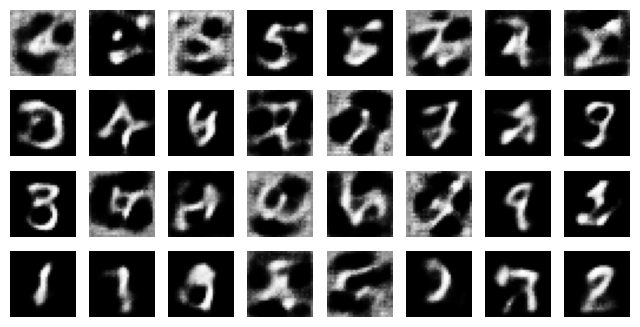

Epoch  2 [ 9,600/48,000] loss=112.561 loss_recon=86.568 loss_kldiv=25.993
Epoch  2 [19,200/48,000] loss=105.689 loss_recon=80.491 loss_kldiv=25.198
Epoch  2 [28,800/48,000] loss=115.453 loss_recon=89.548 loss_kldiv=25.905
Epoch  2 [38,400/48,000] loss=106.008 loss_recon=79.597 loss_kldiv=26.411
Epoch  2 [48,000/48,000] loss=102.488 loss_recon=76.247 loss_kldiv=26.241


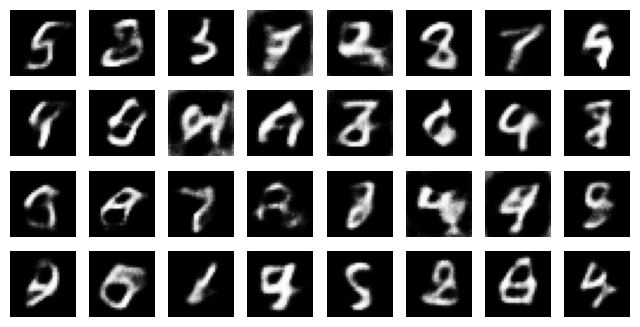

Epoch  3 [ 9,600/48,000] loss=108.978 loss_recon=82.525 loss_kldiv=26.452
Epoch  3 [19,200/48,000] loss=114.466 loss_recon=85.221 loss_kldiv=29.245
Epoch  3 [28,800/48,000] loss=109.345 loss_recon=83.145 loss_kldiv=26.200
Epoch  3 [38,400/48,000] loss=105.944 loss_recon=79.436 loss_kldiv=26.508
Epoch  3 [48,000/48,000] loss=103.717 loss_recon=78.961 loss_kldiv=24.755


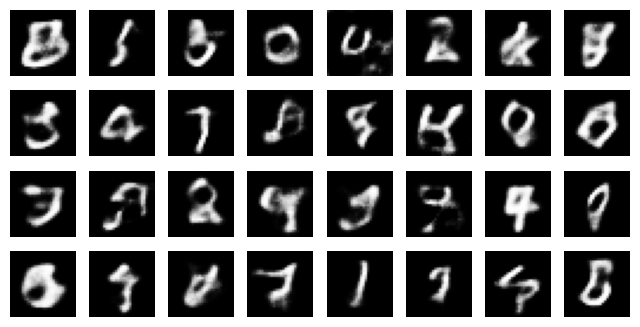

Epoch  4 [ 9,600/48,000] loss=114.324 loss_recon=88.433 loss_kldiv=25.890
Epoch  4 [19,200/48,000] loss=100.186 loss_recon=75.002 loss_kldiv=25.184
Epoch  4 [28,800/48,000] loss=109.563 loss_recon=82.082 loss_kldiv=27.481
Epoch  4 [38,400/48,000] loss=110.486 loss_recon=82.863 loss_kldiv=27.624
Epoch  4 [48,000/48,000] loss=108.015 loss_recon=81.196 loss_kldiv=26.819


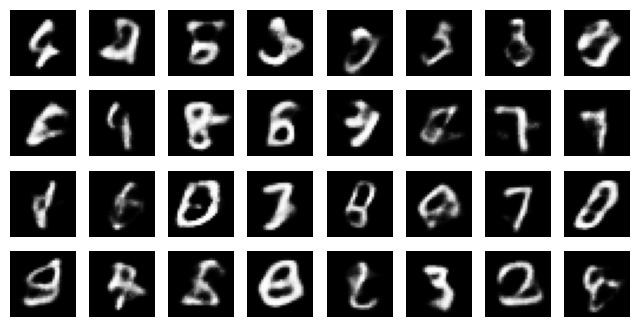

Epoch  5 [ 9,600/48,000] loss=111.160 loss_recon=86.082 loss_kldiv=25.078
Epoch  5 [19,200/48,000] loss=105.545 loss_recon=79.372 loss_kldiv=26.173
Epoch  5 [28,800/48,000] loss=107.369 loss_recon=79.724 loss_kldiv=27.645
Epoch  5 [38,400/48,000] loss=104.419 loss_recon=77.778 loss_kldiv=26.642
Epoch  5 [48,000/48,000] loss=104.869 loss_recon=78.032 loss_kldiv=26.837


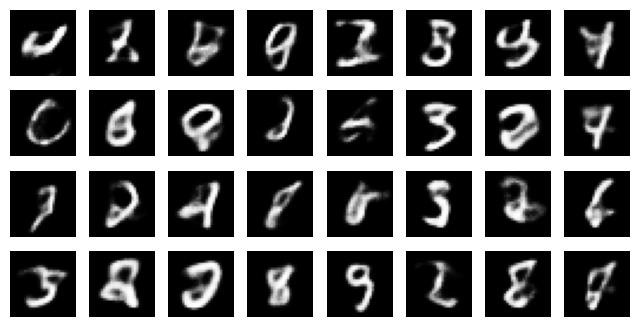

Epoch  6 [ 9,600/48,000] loss=101.198 loss_recon=74.637 loss_kldiv=26.561
Epoch  6 [19,200/48,000] loss=105.125 loss_recon=79.036 loss_kldiv=26.089
Epoch  6 [28,800/48,000] loss=107.274 loss_recon=80.563 loss_kldiv=26.711
Epoch  6 [38,400/48,000] loss=97.773 loss_recon=73.188 loss_kldiv=24.585
Epoch  6 [48,000/48,000] loss=108.462 loss_recon=82.416 loss_kldiv=26.046


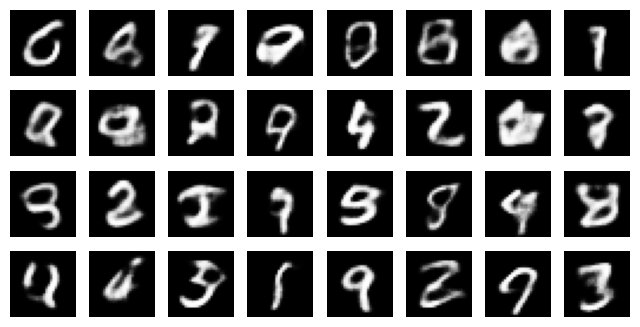

Epoch  7 [ 9,600/48,000] loss=105.954 loss_recon=79.618 loss_kldiv=26.336
Epoch  7 [19,200/48,000] loss=101.670 loss_recon=75.976 loss_kldiv=25.694
Epoch  7 [28,800/48,000] loss=104.072 loss_recon=78.273 loss_kldiv=25.798
Epoch  7 [38,400/48,000] loss=107.105 loss_recon=80.737 loss_kldiv=26.367
Epoch  7 [48,000/48,000] loss=100.955 loss_recon=76.687 loss_kldiv=24.268


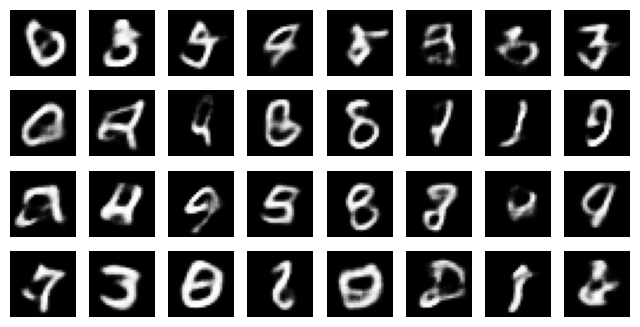

Epoch  8 [ 9,600/48,000] loss=104.231 loss_recon=78.487 loss_kldiv=25.744
Epoch  8 [19,200/48,000] loss=103.490 loss_recon=76.622 loss_kldiv=26.868
Epoch  8 [28,800/48,000] loss=109.216 loss_recon=82.353 loss_kldiv=26.863
Epoch  8 [38,400/48,000] loss=104.154 loss_recon=77.953 loss_kldiv=26.201
Epoch  8 [48,000/48,000] loss=102.584 loss_recon=77.731 loss_kldiv=24.853


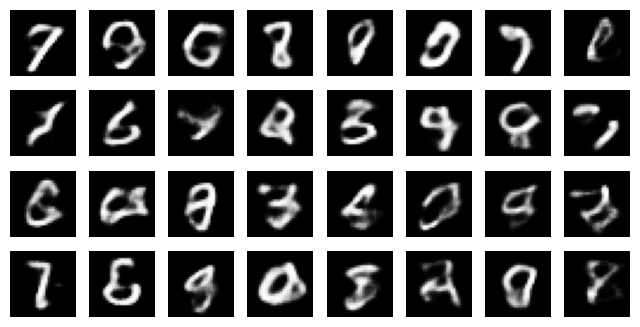

Epoch  9 [ 9,600/48,000] loss=102.999 loss_recon=76.906 loss_kldiv=26.092
Epoch  9 [19,200/48,000] loss=100.000 loss_recon=75.172 loss_kldiv=24.827
Epoch  9 [28,800/48,000] loss=94.544 loss_recon=69.676 loss_kldiv=24.868
Epoch  9 [38,400/48,000] loss=105.471 loss_recon=79.589 loss_kldiv=25.882
Epoch  9 [48,000/48,000] loss=102.885 loss_recon=76.997 loss_kldiv=25.888


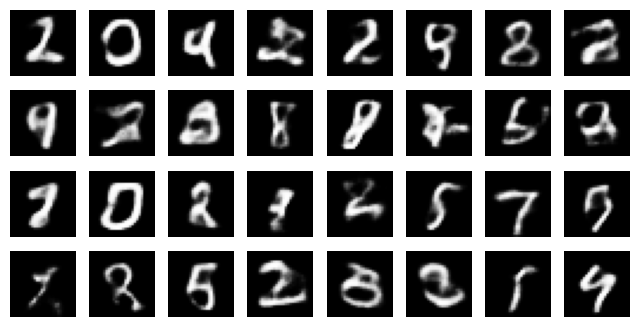

Epoch 10 [ 9,600/48,000] loss=105.665 loss_recon=78.844 loss_kldiv=26.822
Epoch 10 [19,200/48,000] loss=97.595 loss_recon=71.907 loss_kldiv=25.688
Epoch 10 [28,800/48,000] loss=98.085 loss_recon=72.683 loss_kldiv=25.403
Epoch 10 [38,400/48,000] loss=99.026 loss_recon=73.125 loss_kldiv=25.901
Epoch 10 [48,000/48,000] loss=108.364 loss_recon=81.092 loss_kldiv=27.272


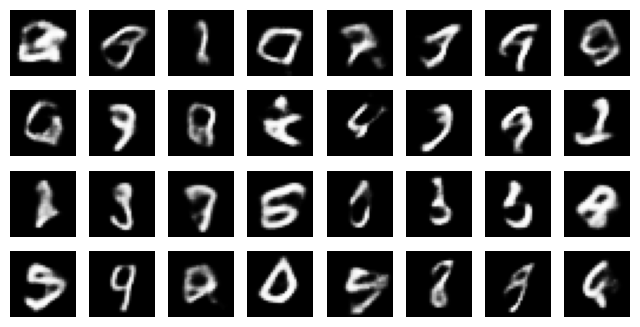

In [ ]:
def vae_loss(
    image: torch.Tensor,
    recon: torch.Tensor,
    mu: torch.Tensor,
    logvar: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    loss_recon = nn.functional.binary_cross_entropy_with_logits(
        recon, image, reduction='sum')
    loss_kldiv = 0.5 * torch.sum(mu**2 + logvar.exp() - 1 - logvar)

    loss_recon /= image.size(0)
    loss_kldiv /= image.size(0)
    loss = loss_recon + loss_kldiv

    return loss, loss_recon.detach(), loss_kldiv.detach()


def train(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epoch: int,
    log_interval: int,
) -> None:
    model.train()
    for batch_idx, (data, _) in enumerate(data_loader, start=1):
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss, loss_recon, loss_kldiv = criterion(data, recon, mu, logvar)

        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Epoch {:>2d} [{:>6,}/{:>6,}] ".format(
                epoch,
                batch_idx * len(data),
                len(data_loader.dataset),
            ) + ' '.join(
                f"{name}={value:.3f}" for name, value in [
                    ('loss', loss.item()),
                    ('loss_recon', loss_recon.item()),
                    ('loss_kldiv', loss_kldiv.item()),
            ]))


def sample_and_visualize(
    model: nn.Module,
    device: torch.device,
    num_rows: int = 4,
    num_cols: int = 8,
) -> None:
    num_samples = num_rows * num_cols
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        samples = model.decode(z)
        # Normalize the pixels to [0, 1] since the model outputs logits.
        samples = samples.sigmoid()

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i, 0].cpu().detach().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()


# TODO
# Feel free to add other hyperparameters.
num_epochs: int = 10
learning_rate: float = 1e-3
latent_dim: int = 20

vae = VAE(latent_dim=latent_dim).to(device)
criterion = vae_loss
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs+1):
    train(vae, train_loader, criterion, optimizer, device, epoch, 150)
    sample_and_visualize(vae, device)

torch.save(vae.state_dict(), 'mnist_vae.pth')

### 2d. Generate Images and Evaluate (5 points)

In the following cell, generate 10,000 sample images using your trained VAE.
Calculate and report the Inception Score on the generated images.

To receive full credit, your VAE should achieve a mean Inception Score of at
least 3.00.

In [ ]:
vae.eval()
with torch.no_grad():
    all_samples = []
    batch_size = 1000
    num_batches = 10
    for _ in range(num_batches):
        z = torch.randn(batch_size, vae.latent_dim).to(device)
        batch_samples = vae.decode(z)
        batch_samples = batch_samples.sigmoid()  # Convert logits to pixel values in [0, 1]
        all_samples.append(batch_samples.cpu())

    samples = torch.cat(all_samples, dim=0)

data_loader = torch.utils.data.DataLoader(samples, batch_size=64)
mean, std = compute_inception_score(cnn, data_loader, device)
print("Inception score: {:.2f}±{:.2f}".format(mean, std))

Inception score: 6.48±0.08
